<a href="https://colab.research.google.com/github/harishmuh/machine_learning_practices/blob/main/Classification_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----
# **Exercise: Metrics for Classification**
---
Hello data enthusiast,

In this tutorial, we’ll work with a dataset called Employee.csv.

Our tasks:
* Load the Employee.csv dataset.

* Choose the right evaluation metric based on the business problem.

* Perform Exploratory Data Analysis (EDA) to better understand the data.

* Use Cross Validation to select the best model.

* Try tuning the best model to improve its performance.

* Identify which features are most important for the prediction.

Steps:
1. Load Dataset
2. EDA
3. Define X and y
4. Split the data into train/test
5. Preprocess the data
6. Use Cross Validation to find the best model
7. Tune the best model (Hyperparameter Tuning)
8. Make predictions on the test set

In [1]:
# Installing library
!pip install category_encoders # Not available in colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00


In [2]:
# Importing required libraries

# Data wrangling
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# remove warning
import warnings
warnings.filterwarnings('ignore')

# style (ggplot)
plt.style.use('ggplot')

## **Business Understanding**
The HR department has employee records from the past few years. These records include information about employees who stayed and those who resigned.

**Business problem**

Sometimes, HR doesn't realize that an employee is planning to resign.

**Why the metric matters:**

**False Positive (FP)**

The model predicts an employee will resign, but they were actually going to stay.

* In this case, the company might offer a counter offer (like a significant raise) to try to retain the employee.

* The raise costs the company 30% of the employee’s current salary.

* In our case, let's assume this raise costs **IDR 2 million**.

* But this cost is unnecessary because the employee was going to stay anyway!

**False Negative (FN)**

The model predicts an employee will stay, but they actually resign.

* HR doesn’t prepare for this resignation or plan a replacement.

* As a result, the company spends money to recruit and train a new employee.

* Let's assume this cost is **IDR 10 million**.

* This is a bigger loss compared to giving a counter offer.



Since **the cost of a False Negative (FN) is much higher** (about 5x larger) than a False Positive (FP), the most important metric to focus on here is **Recall**.


## **1. Load Dataset**

In [3]:
# Loading dataset 'Employee.csv'
url = 'https://raw.githubusercontent.com/harishmuh/machine_learning_practices/refs/heads/main/datasets/Employee.csv'
df = pd.read_csv(url)
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [4]:
# Data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [5]:
# Statistical descriptive
df.describe(include='all')

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
count,4653,4653.000000,4653,4653.000000,4653.000000,4653,4653,4653.000000,4653.000000
unique,3,NaN,3,NaN,NaN,2,2,NaN,NaN
top,Bachelors,NaN,Bangalore,NaN,NaN,Male,No,NaN,NaN
freq,3601,NaN,2228,NaN,NaN,2778,4175,NaN,NaN
mean,NaN,2015.062970,NaN,2.698259,29.393295,NaN,NaN,2.905652,0.343864
std,NaN,1.863377,NaN,0.561435,4.826087,NaN,NaN,1.558240,0.475047
min,NaN,2012.000000,NaN,1.000000,22.000000,NaN,NaN,0.000000,0.000000
25%,NaN,2013.000000,NaN,3.000000,26.000000,NaN,NaN,2.000000,0.000000
50%,NaN,2015.000000,NaN,3.000000,28.000000,NaN,NaN,3.000000,0.000000
75%,NaN,2017.000000,NaN,3.000000,32.000000,NaN,NaN,4.000000,1.000000


In [6]:
# Checking missing values
df.isna().sum()

,0
Education,0
JoiningYear,0
City,0
PaymentTier,0
Age,0
Gender,0
EverBenched,0
ExperienceInCurrentDomain,0
LeaveOrNot,0


In [7]:
# Checking duplicates
df.duplicated().sum()

np.int64(1889)

In [8]:
# Data dimension (Shape)
df.shape

(4653, 9)

In [9]:
# Drop duplicates
df = df.drop_duplicates()
df.shape

(2764, 9)

In [10]:
# Imbalanced data check
df['LeaveOrNot'].value_counts()

,count
LeaveOrNot,
0,1676
1,1088


In [11]:
# Imbalanced data percentage
df['LeaveOrNot'].value_counts() / len(df)
# The data is relatively imbalance, consequently we will not use accuracy

,count
LeaveOrNot,
0,0.606368
1,0.393632


## **2. EDA**

In [12]:
# Numerical features
num_feature = df.describe().columns
num_feature

Index(['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain',
       'LeaveOrNot'],
      dtype='object')

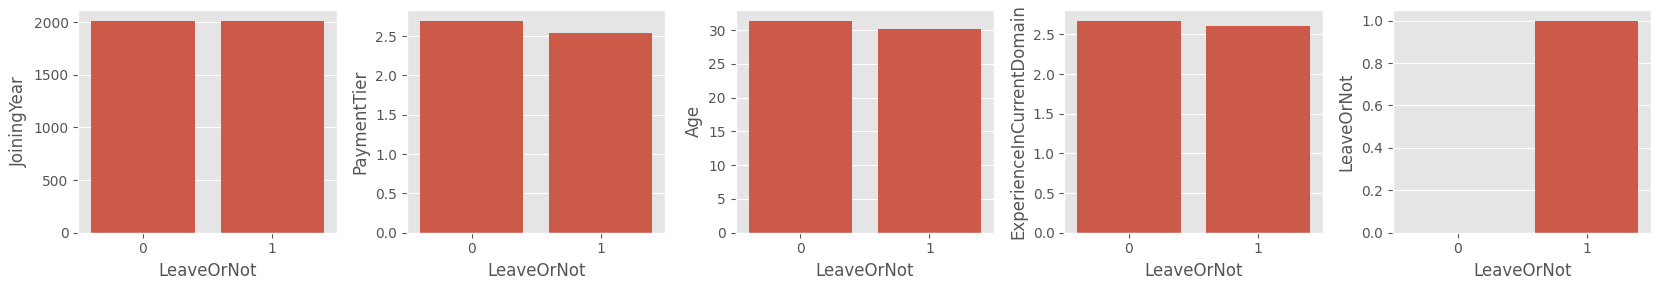

In [13]:
# EDA numerical feature
plt.figure(figsize=(20,3))

for col in range(len(num_feature)):

    plt.subplot(1,6, col+1)
    sns.barplot(data=df, x='LeaveOrNot', y=num_feature[col], ci=0)

plt.tight_layout()

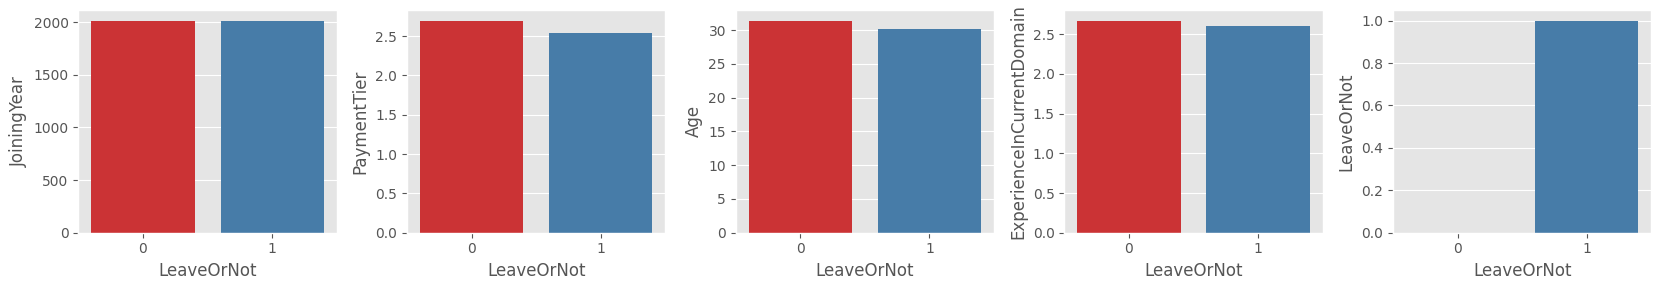

In [63]:
# EDA numerical feature
plt.figure(figsize=(20,3))

for col in range(len(num_feature)):

    plt.subplot(1,6, col+1)
    sns.barplot(data=df, x='LeaveOrNot', y=num_feature[col], ci=0, palette='Set1')

plt.tight_layout()

In [14]:
# Categorical features
cat_feature = df.describe(include='object').columns
cat_feature = list(cat_feature) + ['PaymentTier', 'ExperienceInCurrentDomain']
cat_feature

['Education',
 'City',
 'Gender',
 'EverBenched',
 'PaymentTier',
 'ExperienceInCurrentDomain']

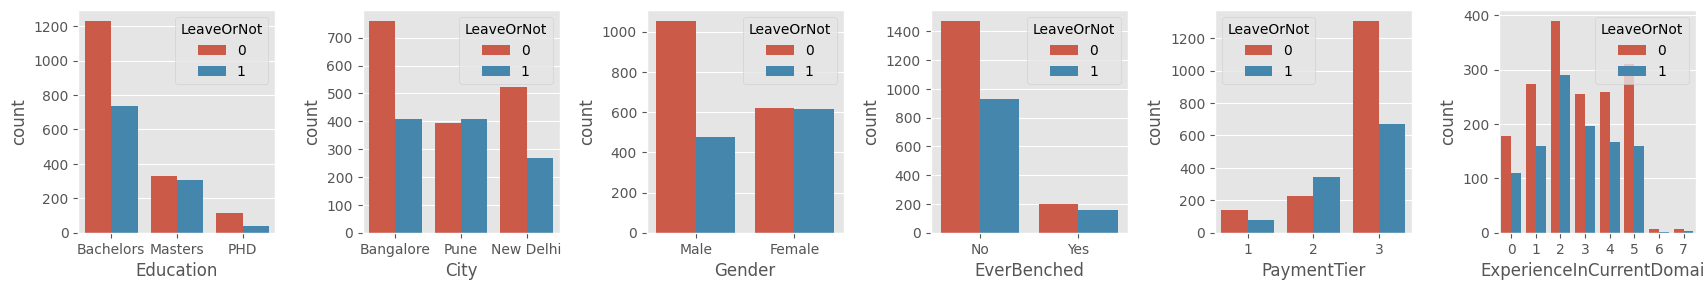

In [15]:
# EDA Categorical features
plt.figure(figsize=(20,3))

for col in range(len(cat_feature)):

    plt.subplot(1,len(cat_feature)+1, col+1)
    sns.countplot(data=df, x=cat_feature[col], hue='LeaveOrNot')

plt.tight_layout()

In [16]:
# result.params

## **3. Defining features (X) and target (y)**

In [17]:
# Defining features and target
X = df.drop(columns='LeaveOrNot')
y = df['LeaveOrNot']

## **4. Data Splitting**

In [18]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## **5. Preprocessing**

Scaling:
- Robust: numerical features + Education

Encoding:
- onehot encoder: City, Gender, EverBenched
- ordinal encoder: Education

In [19]:
# mapping for Education feature
mapper = [
    {'col':'Education', 'mapping':{'Bachelors':1, 'Masters':2, 'PHD':3}}
]

# pipeline for ordinal encoding
pipe_encode_scale = Pipeline([
    ('encoder', OrdinalEncoder(mapping=mapper)),
    ('scaler', RobustScaler())
])

In [20]:
X_train.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain'],
      dtype='object')

In [21]:
X_train.head(3)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
38,Bachelors,2017,Pune,2,29,Female,No,2
2790,Bachelors,2013,Bangalore,3,30,Female,No,5
2388,Bachelors,2015,Pune,2,29,Female,Yes,1


In [22]:
# Define transformer # Preprocessing
transformer = ColumnTransformer([
    ('scaling', RobustScaler(), ['JoiningYear','PaymentTier','Age','ExperienceInCurrentDomain']),
    ('pipe_encode_scale', pipe_encode_scale, ['Education']),
    ('encoder', OneHotEncoder(), ['City','Gender','EverBenched']),
])

## **6. Cross Val**

In [23]:
# Defining algorithms
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)

In [25]:
# Modeling
# list of algorithms
list_algo = [logreg, knn, tree]

list_all_score = []
list_mean = []
list_std = []

# looping through pipeline and cross validation
for algo in list_algo:

    # pipeline that connect preprocessing dan modeling
    # preventing information leakage
    pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', algo)
    ])

    # cross validation
    cv_score = cross_val_score(
        estimator= pipe_model,  # model
        X = X_train,            # X_train
        y = y_train,            # y_train
        cv = 5,                 # how many cross validation fold
        scoring= 'recall'       # metric
    )

    list_all_score.append(cv_score.round(2))
    list_mean.append(cv_score.mean())
    list_std.append(cv_score.std())

In [26]:
df_cv = pd.DataFrame()
df_cv['algo'] = list_algo
df_cv['mean_recall'] = list_mean
df_cv['std_recall'] = list_std
df_cv['all_recall'] = list_all_score

df_cv

,algo,mean_recall,std_recall,all_recall
0,LogisticRegression(random_state=0),0.409195,0.050287,"[0.4, 0.4, 0.5, 0.4, 0.34]"
1,KNeighborsClassifier(),0.543678,0.033629,"[0.59, 0.57, 0.55, 0.49, 0.52]"
2,DecisionTreeClassifier(random_state=0),0.610345,0.037844,"[0.66, 0.57, 0.64, 0.56, 0.61]"


## **7. Hyperparameter Tuning**

In [27]:
# Hyperparameter tuning
# Setting param_grid
hyperparam = {
    'modeling__max_depth': range(1,30,1),
    'modeling__min_samples_split': range(2,100,5),
    'modeling__min_samples_leaf': range(2,100,5),
}

# estimator
pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', tree)
    ])

# define gridsearch
gridsearch = GridSearchCV(
    estimator= pipe_model,
    param_grid= hyperparam,
    cv = 5,
    scoring='recall',
    n_jobs= -1
)

In [28]:
# fit
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaling',
                                                                         RobustScaler(),
                                                                         ['JoiningYear',
                                                                          'PaymentTier',
                                                                          'Age',
                                                                          'ExperienceInCurrentDomain']),
                                                                        ('pipe_encode_scale',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OrdinalEncoder(mapping=[{'col': 'Education',
                                                                                                                   'data_type': dtype('O'),
                                                                                                                   'mapping': Bachelors    1
Masters      2
PHD          3
dtype: int64}])),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['Education']),
                                                                        ('encoder',
                                                                         OneHotEncoder(),
                                                                         ['City',
                                                                          'Gender',
                                                                          'EverBenched'])])),
                                       ('modeling',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'modeling__max_depth': range(1, 30),
                         'modeling__min_samples_leaf': range(2, 100, 5),
                         'modeling__min_samples_split': range(2, 100, 5)},
             scoring='recall')

In [29]:
# Gridsearch result

df_grid = pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')
df_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modeling__max_depth,param_modeling__min_samples_leaf,param_modeling__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6829,0.037723,0.006927,0.015854,0.000626,18,7,47,"{'modeling__max_depth': 18, 'modeling__min_sam...",0.649425,0.66092,0.712644,0.678161,0.637931,0.667816,0.026059,1
3629,0.032497,0.002723,0.016849,0.002257,10,7,47,"{'modeling__max_depth': 10, 'modeling__min_sam...",0.649425,0.66092,0.712644,0.678161,0.637931,0.667816,0.026059,1
4029,0.031306,0.003291,0.020131,0.010587,11,7,47,"{'modeling__max_depth': 11, 'modeling__min_sam...",0.649425,0.66092,0.712644,0.678161,0.637931,0.667816,0.026059,1
5629,0.057381,0.010713,0.025658,0.008358,15,7,47,"{'modeling__max_depth': 15, 'modeling__min_sam...",0.649425,0.66092,0.712644,0.678161,0.637931,0.667816,0.026059,1
10829,0.031497,0.003914,0.014970,0.000416,28,7,47,"{'modeling__max_depth': 28, 'modeling__min_sam...",0.649425,0.66092,0.712644,0.678161,0.637931,0.667816,0.026059,1


In [30]:
# Gridsearch best parameters
gridsearch.best_params_

{'modeling__max_depth': 10,
 'modeling__min_samples_leaf': 7,
 'modeling__min_samples_split': 47}

In [31]:
# Gridsearch best score
gridsearch.best_score_

np.float64(0.667816091954023)

In [52]:
# Comparison
print('Mean recall after tuning: ', df_cv.loc[2, 'mean_recall'])
print('std recall before tuning: ', df_cv.loc[2, 'std_recall'])
print('-'*50)
print('Mean recall after tuning: ', gridsearch.best_score_)
print('std recall after tuning: ', df_grid.iloc[0, -2])

Mean recall after tuning:  0.6103448275862069
std recall before tuning:  0.037843856627941
--------------------------------------------------
Mean recall after tuning:  0.667816091954023
std recall after tuning:  0.026059273675297992


On the training set,tuning the model improved the average recall and made it more consistent (lower standard deviation).
This means the model became better at detecting resignations and is more stable across different subsets (cross-validation).

## **8. Predict to Test Set**

**Before Tuning**

In [33]:
# Define model # Decision Tree Classifier
model = tree

# Model
pipe_model = Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

# Model training
pipe_model.fit(X_train, y_train)

# Model predicting on test set
y_pred_benchmark = pipe_model.predict(X_test)

# Recall score
recall_score(y_test, y_pred_benchmark)

0.6055045871559633

**After Tuning**

In [34]:
# Model
best_model = gridsearch.best_estimator_

# Model training
best_model.fit(X_train, y_train)

# Model predicting test set
y_pred_best = best_model.predict(X_test)

# Recall score
recall_score(y_test, y_pred_best)

0.6055045871559633

In [35]:
print('Recall score before tuning', recall_score(y_test, y_pred_benchmark))
print('Recall score after tuning ', recall_score(y_test, y_pred_best))

Recall before tuning 0.6055045871559633
Recall after tuning  0.6055045871559633


## **9. Other Metrics**

In [36]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc
)


In [37]:
# Before tuning
confusion_matrix(y_test, y_pred_benchmark)

array([[238,  97],
       [ 86, 132]])

In [38]:
# After tuning
confusion_matrix(y_test, y_pred_best)

array([[290,  45],
       [ 86, 132]])

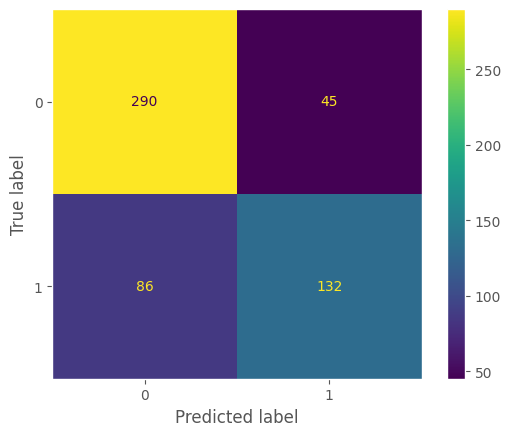

In [54]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.grid(False)
plt.show()

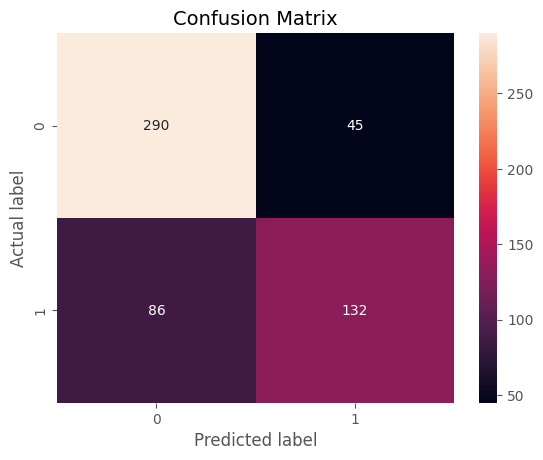

In [60]:
# Confusion matrix
sns.heatmap(
    data=confusion_matrix(y_test, y_pred_best),
    annot=True,
    fmt='.0f'
)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix', size=14)
plt.show()

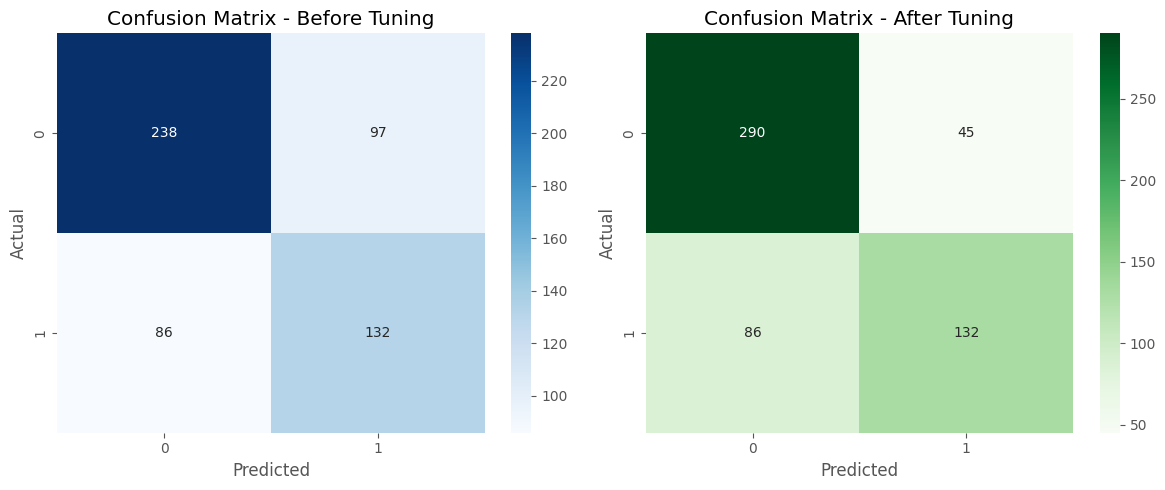

In [64]:
# Confusion metrics
# y_test (true labels)
# y_pred_benchmark (predictions before tuning)
# y_pred_best (predictions after tuning)

# Create confusion matrices
cm_before = confusion_matrix(y_test, y_pred_benchmark)
cm_after = confusion_matrix(y_test, y_pred_best)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix before tuning
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Before Tuning')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot confusion matrix after tuning
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - After Tuning')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


**Confusion matrix explanation and interpretation**

* After tuning, the model became much better at predicting people who stay (FP).

* But the model did not become better at catching people who will resign (TP and FN unchanged).

* In this case, because missing resignations (FN) is more expensive, this tuning did not solve the main business problem.

In [41]:
# Classification report before tuning
print(classification_report(y_test, y_pred_benchmark))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       335
           1       0.58      0.61      0.59       218

    accuracy                           0.67       553
   macro avg       0.66      0.66      0.66       553
weighted avg       0.67      0.67      0.67       553



In [42]:
# Classification report after tuning
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       335
           1       0.75      0.61      0.67       218

    accuracy                           0.76       553
   macro avg       0.76      0.74      0.74       553
weighted avg       0.76      0.76      0.76       553



**Classification report interpretation**

* After tuning the model, we improved the overall accuracy from 67% to 76%.
* The model became much better at correctly predicting which employees will resign, with precision improving from 58% to 75%.
* Although recall for resignations stayed the same at 61%, the tuned model may reduce unnecessary counter offers, saving company costs.

### **Precision Recall Curve**

The Precision-Recall curve helps visualize how different thresholds affect the performance of a classification model.

The Average Precision (AP) value shown on the Precision-Recall curve represents the average precision across all thresholds.

In [43]:
# predict probabilities
y_pred_proba = best_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_pred_proba = y_pred_proba[:, 1]

# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

In [44]:
df_pr_curve = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'thresholds': list(thresholds) + [0]
}).sort_values('precision', ascending=False)

df_pr_curve.head()

,precision,recall,thresholds
49,1.000000,0.366972,1.000000
50,1.000000,0.000000,0.000000
48,0.923077,0.385321,0.785714
47,0.914894,0.394495,0.736842
46,0.909910,0.463303,0.733333


''

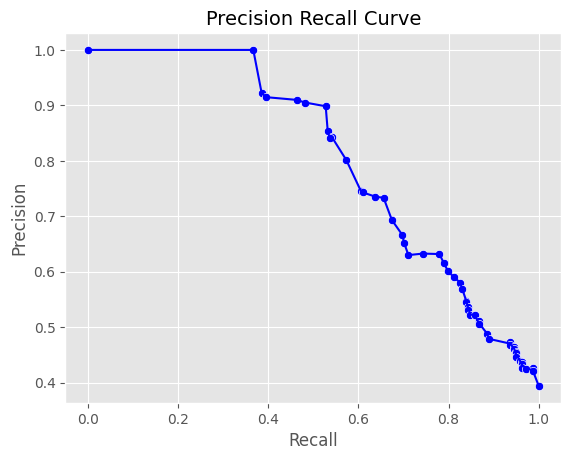

In [45]:
# How to make Precision Recall Curve (manually)

sns.lineplot(data=df_pr_curve, x='recall', y='precision', color='b')
sns.scatterplot(data=df_pr_curve, x='recall', y='precision', color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve', size=14)

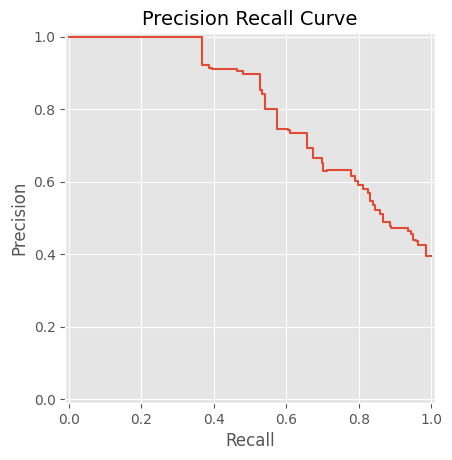

In [57]:
# We can also use 'PrecisionRecallDisplay'
PrecisionRecallDisplay(precision, recall).plot()
plt.title('Precision Recall Curve', size=14)
plt.show()

### **ROC AUC curve**

ROC --> Probability Curve

In binary classification tasks, the ROC AUC curve is particularly appropriate when both classes are of interest.

The ROC AUC score represents the area under the ROC curve. It measures how effectively the model can distinguish between the two classes.

A classifier that achieves 100% correct predictions will have a ROC AUC score of 1, while the poorest performance, equivalent to random guessing, corresponds to a ROC AUC score of 0.5.

In [47]:
# predict probabilities
y_pred_proba = best_model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_pred_proba = y_pred_proba[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [48]:
# ROC AUC score
auc(fpr, tpr)

np.float64(0.8180062987813227)

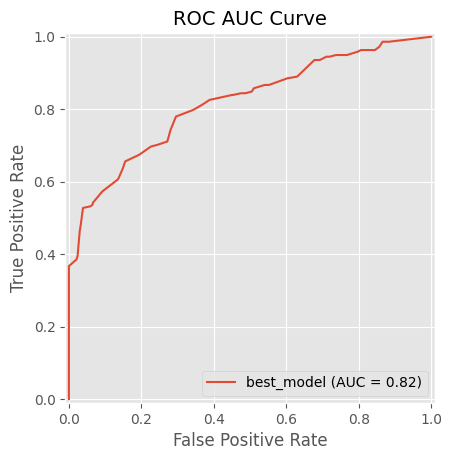

In [58]:
# ROC AUC display
RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=auc(fpr, tpr),
    estimator_name='best_model'
).plot();

plt.title('ROC AUC Curve', size=14)
plt.show()

The ROC AUC score of 0.82 is considered as very good. The model has strong discriminatory power to correctly classify between both class, negative and positive class.